## Import Libraries

In [1]:
from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from keras.models import Model
from keras.applications import VGG16
from keras.models import Sequential ,load_model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D


## Google Drive connection

In [2]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Utilities

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras import backend as K
from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score

dataset_path = "/content/drive/MyDrive/DiDonato_Giorgi"

# path about the preprocessed dataset
base_path = "/content/drive/MyDrive/DiDonato_Giorgi/Preprocessed/Unified"

# path about test, train and validation sets
test_path = "/content/drive/MyDrive/DiDonato_Giorgi/Preprocessed/CLAHE/Test"
val_path = "/content/drive/MyDrive/DiDonato_Giorgi/Preprocessed/CLAHE/Validation"
train_path = "/content/drive/MyDrive/DiDonato_Giorgi/Preprocessed/CLAHE/Train"

models_path = "/content/drive/MyDrive/DiDonato_Giorgi/Models/CLAHE"
cnn_results_path = os.path.join(models_path, 'CNN')
vgg16_results_path = os.path.join(models_path, 'VGG16')
resnet50_results_path = os.path.join(models_path, 'ResNet50')
inceptionv3_results_path = os.path.join(models_path, 'InceptionV3')
# actual_results_path = vgg16_results_path

def set_seed ():
	''' 
	set_seed is used to obtain reproducible results using keras during the development phase
	'''
	seed = 10
	# The below is necessary for reproducible results of certain Python hash-based operations.
	os.environ["PYTHONHASHSEED"]="0"
	# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
	np.random.seed(seed)
	# The below is necessary for starting core Python generated random numbers in a well-defined state.
	rn.seed(seed)
	# The below tf.random.set_seed will make x number generation in TensorFlow have a well-defined initial state.
	tf.random.set_seed(seed)     

# image size
image_size = 224
batch_size = 32

# create the generators for data augmentation with rescaling
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# load train, test and validation sets
train_generator = data_generator.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = data_generator.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

val_generator = data_generator.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)
     

def show_training_and_validation_performance(history,path):
	'''
	show_training_and_validation_performance is used to plot the performances during the training phase
	:param history: object in which are recorded all the events
	'''
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']

	epochs = range(len(acc))

	plt.plot(epochs, acc, 'bo', label='Training accuracy')
	plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
	plt.title('Training and validation accuracy')
	plt.legend()

	plt.figure()

	plt.plot(epochs, loss, 'bo', label='Training loss')
	plt.plot(epochs, val_loss, 'b', label='Validation loss')
	plt.title('Training and validation loss')
	plt.legend()

	plt.savefig(path)

	plt.show()

def compile_model (model, optimizer='adam', learning_rate = 0.001):
	'''
	compile_model is used to compile the current model
	:param model: model to compile
	:param optimizer: optimizer to be used
	:param learning_rate: learning rate parameter for the optimizer
	'''
	if optimizer == 'adam':
		model.compile(loss="categorical_crossentropy",
		optimizer=optimizers.Adam(learning_rate=learning_rate),
		metrics=["accuracy"])
	elif optimizer == 'rmsprop':
		model.compile(loss="categorical_crossentropy",
					optimizer = optimizers.RMSprop(learning_rate=learning_rate),
					metrics=['accuracy'])
	model.summary()

def run_model (model, type, model_name, epochs = 100, patience=5, monitor='val_loss'):
	'''
	run_model is used to run the current mode
	:param model: model to run
	:param model_name: name given to save the model
	:param type: type of model, CNN, VGG16, ResNet50, InceptionV3
	:param epochs: how many epochs to do
	:param patience: patience value for Early Stopping
	:param monitor: what to monitor for Early Stopping and Model Checkpoint
	'''
	# local save path for the models
	save_path = os.path.join(models_path, type + '/' + model_name + '.h5') 
	callbacks_list = [
					keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
					keras.callbacks.ModelCheckpoint(
						filepath = save_path,
						monitor=monitor,
						verbose=1,
						save_best_only=True)
					]
	history = model.fit(train_generator,
						epochs=epochs,
						validation_data=val_generator,
						callbacks=callbacks_list)
	# save on Drive only the best model
	show_training_and_validation_performance(history,os.path.join(models_path, type + '/' + model_name + '_validation.png'))

def plot_roc_curve(y_true, y_pred, n_classes, class_labels, model_name, type):

    # label conversion to binary format
    lb = LabelBinarizer()
    y_true_binary = lb.fit_transform(y_true)

    # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'red', 'green', 'orange']

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve {0} ({1:0.2f}%)'.format(class_labels[i], roc_auc[i]*100))

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(models_path, type + '/' + model_name + '_ROC.png'))
    plt.show()

def evaluate_model (model, test_generator, model_name, type):
	'''
	evaluate_model is used to plot some statistics about the performance on the test set
	:param model: model to consider
	'''
	labels_d= ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

	# get predictions
	y_score = model.predict(test_generator)
	# convert predictions to classes
	y_pred = np.argmax(y_score, axis=-1)
	# get true classes
	y_true = test_generator.classes
	# extract class labels
	class_labels = list(test_generator.class_indices.keys())
	
	print("Classification report: ")
	# create and show classification report
	print(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))
	# save classification report
	with open(os.path.join(models_path, type + '/' + model_name + '_classification_report.txt'), 'w') as f:
		f.write(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))

	# create and show confusion matrix	
	cm = confusion_matrix(y_true, y_pred)	
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
	disp.plot(xticks_rotation=45)
	
	# save confusion matrix
	plt.savefig(os.path.join(models_path, type, model_name + '_confusion_matrix.png'), bbox_inches='tight', pad_inches=0.1)
	plt.show()

	plot_roc_curve(y_true, y_score, 4, class_labels, model_name, type)

def get_index_by_layer_name(model, layer_name):
  '''
  get_index_by_layer_name is used to retrieve the index of a specific layer
  :param model: model to check
  :param layer_name: name of the layer we want to get the index of
  :return: the index of the layer named as defined in layer_name
  '''
  for index, layer in enumerate(model.layers):
      if layer.name == layer_name:
          return index 

def clear(model):
	del model
	K.clear_session() 

set_seed ()

Found 4520 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 652 images belonging to 4 classes.


# Load ResNet-50

In [4]:
# load the pretrained model without the top layer 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

# Feature extraction

## Experiment 1 
Start using flatten layer and one dense layer with 256 neurons

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_18 (Dense)            (None, 256)               25690368  
                                                                 
 dense_19 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 25,691,396
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 2.6386 - accuracy: 0.4923
Epoch 1: val_loss improved from inf to 1.04924, saving model to /con

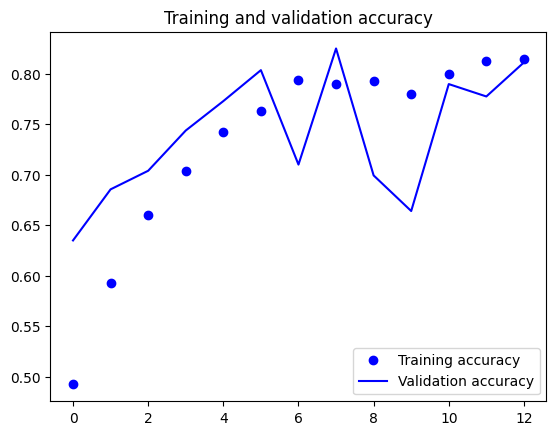

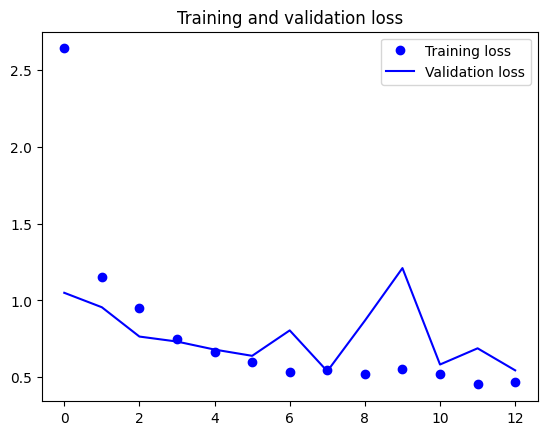

21/21 [==============================] - 4s 143ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.7356    0.8270    0.7786       185
meningioma_tumor     0.8462    0.5294    0.6513       187
        no_tumor     0.7037    0.9500    0.8085       100
 pituitary_tumor     0.8854    0.9444    0.9140       180

        accuracy                         0.7929       652
       macro avg     0.7927    0.8127    0.7881       652
    weighted avg     0.8038    0.7929    0.7841       652



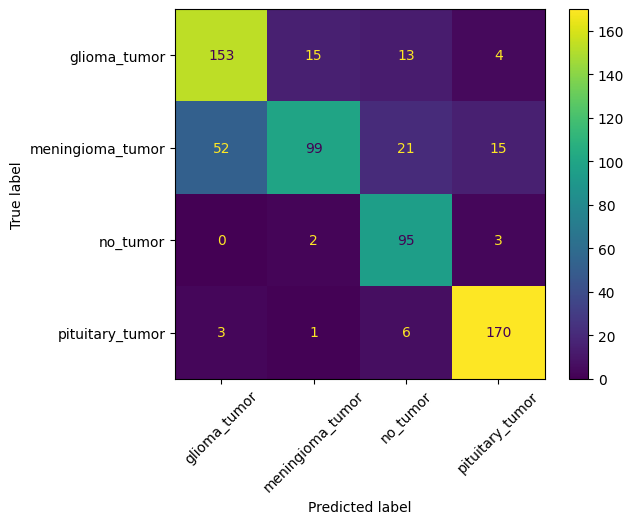

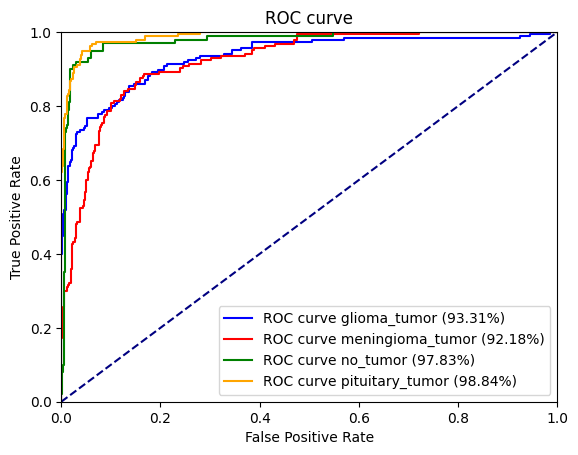

In [12]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax')) #4 classi di output

# freeze the layers of the pretrained model
for layer in base_model.layers:
    layer.trainable = False

# compile the model
compile_model(model)

# run the model
run_model(model, 'ResNet50', "ResNet-50_256_clahe")

# evaluate the model
evaluate_model(model, test_generator, "ResNet-50_256_clahe", "ResNet50")

## Experiment 2
Try to fight overfitting adding dropout layers to the previous experiment

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 25,691,396
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
142/142 [============

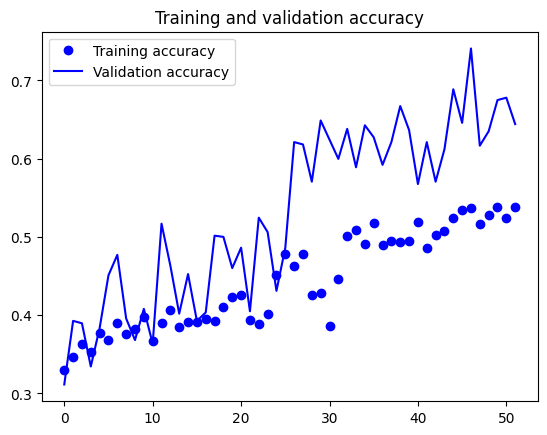

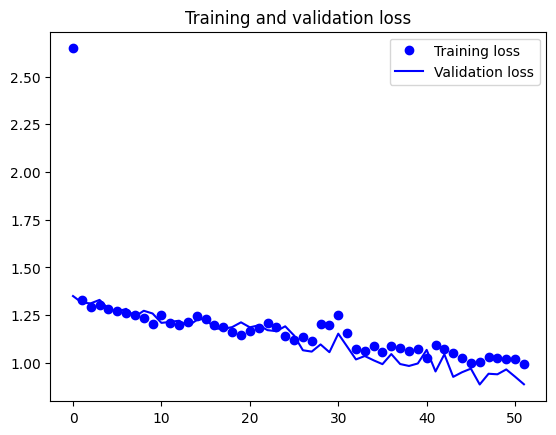

21/21 [==============================] - 4s 152ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.4500    0.0973    0.1600       185
meningioma_tumor     0.4712    0.7861    0.5892       187
        no_tumor     0.7642    0.9400    0.8430       100
 pituitary_tumor     0.8927    0.8778    0.8852       180

        accuracy                         0.6396       652
       macro avg     0.6445    0.6753    0.6193       652
    weighted avg     0.6265    0.6396    0.5881       652



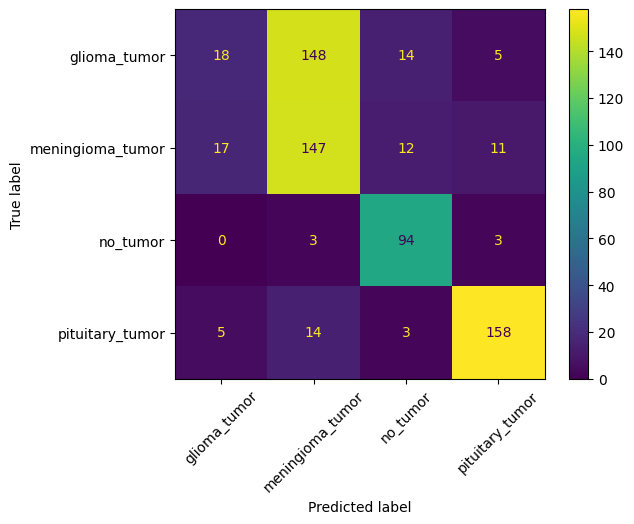

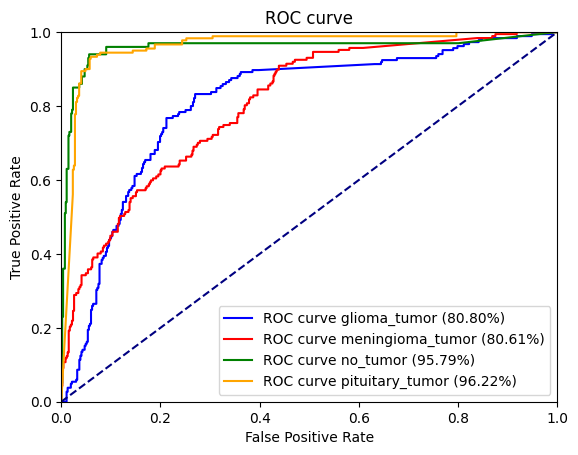

In [6]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax')) #4 classi di output

# freeze the layers of the pretrained model
for layer in base_model.layers:
    layer.trainable = False

# compile the model
compile_model(model)

# run the model
run_model(model,'ResNet50', "ResNet-50_256_dropout_clahe")

# evaluate the model
evaluate_model(model, test_generator, "ResNet-50_256_dropout_clahe", "ResNet50")

## Experiment 8
Adding a dropout layer we can see a underfitting scenario. We try to solve it using two dense layers with 128 neurons each increasing the complexity of the network.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               12845184  
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 4)                 516       
                                                                 
Total params: 36,449,924
Trainable params: 12,862,212
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
142/142 [============

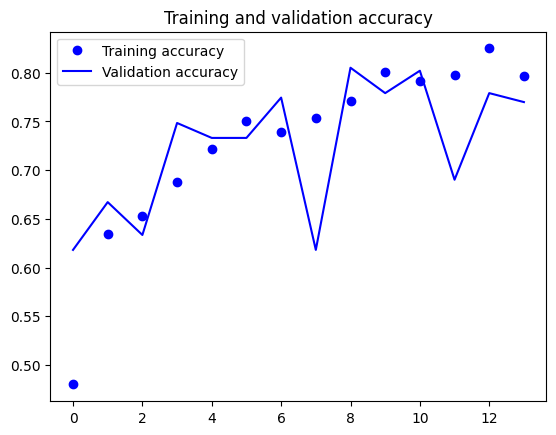

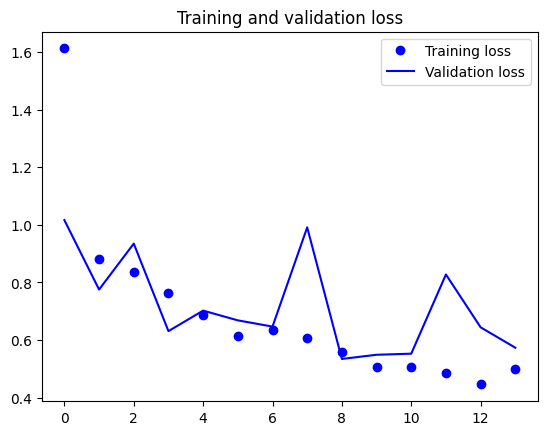

21/21 [==============================] - 4s 143ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.6074    0.8865    0.7209       185
meningioma_tumor     0.7810    0.4385    0.5616       187
        no_tumor     0.9024    0.7400    0.8132       100
 pituitary_tumor     0.8821    0.9556    0.9173       180

        accuracy                         0.7546       652
       macro avg     0.7932    0.7551    0.7533       652
    weighted avg     0.7783    0.7546    0.7436       652



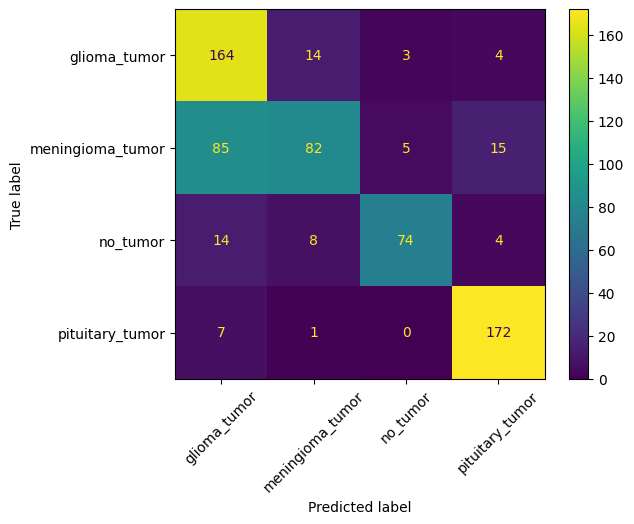

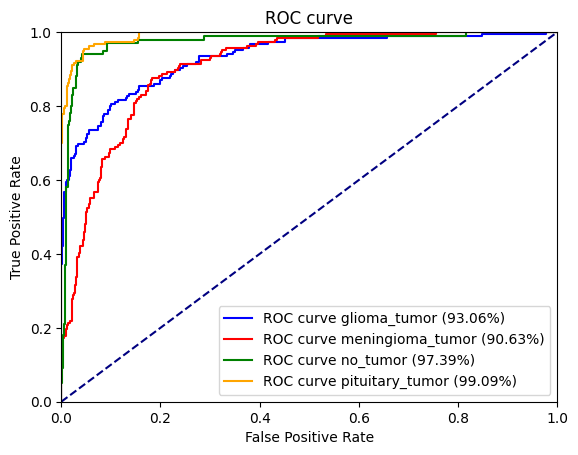

In [7]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax')) #4 classi di output

# freeze the layers of the pretrained model
for layer in base_model.layers:
    layer.trainable = False

# compile the model
compile_model(model)

# run the model
run_model(model, 'ResNet50', "ResNet-50_128_128_clahe")

# evaluate the model
evaluate_model(model, test_generator, "ResNet-50_128_128_clahe", "ResNet50")

## Experiment 4

To resolve the previous problem we try to use GlobalAveragePooling2D instead of flatten layer and we add a dense layer with 512 neurons.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_7 (Dense)             (None, 512)               1049088   
                                                                 
 dense_8 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 1.2226 - accuracy: 0.4520
Epo

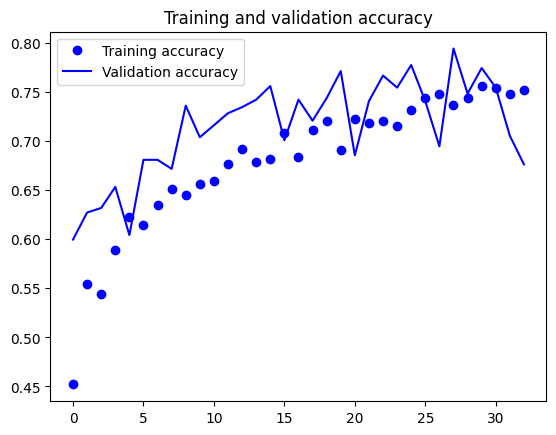

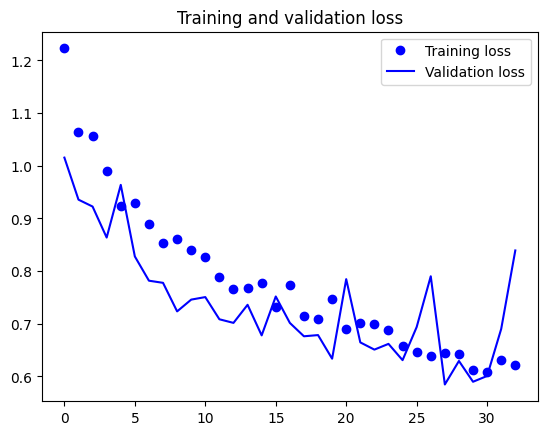

21/21 [==============================] - 4s 148ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.8586    0.4595    0.5986       185
meningioma_tumor     0.5826    0.7166    0.6427       187
        no_tumor     0.4286    0.9300    0.5868       100
 pituitary_tumor     0.9717    0.5722    0.7203       180

        accuracy                         0.6365       652
       macro avg     0.7104    0.6696    0.6371       652
    weighted avg     0.7447    0.6365    0.6430       652



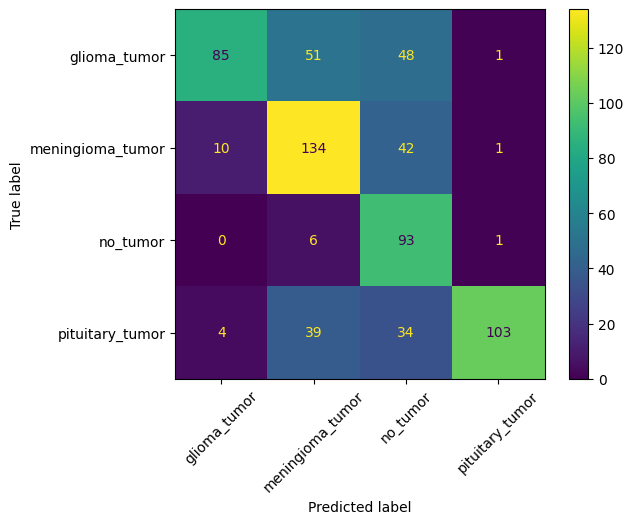

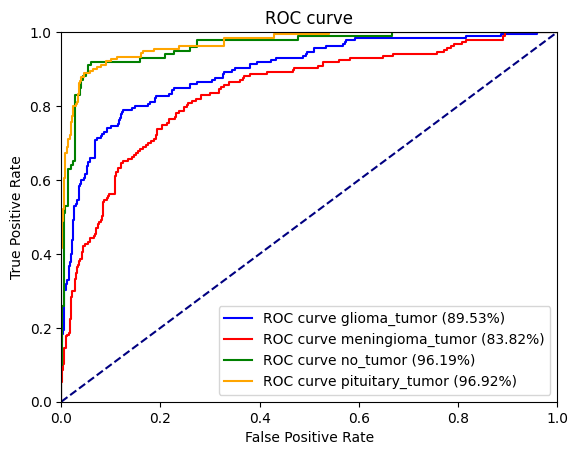

In [8]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax')) #4 classi di output

# freeze the layers of the pretrained model
for layer in base_model.layers:
    layer.trainable = False

# compile the model
compile_model(model)

# run the model
run_model(model, 'ResNet50', "ResNet-50_512_globAvgPool_clahe")

# evaluate the model
evaluate_model(model,test_generator, "ResNet-50_512_globAvgPool_clahe", "ResNet50")

## Experiment 6

The previous experiment shows a underfitting scenario. We try to solve it adding a dense layer with 512 neurons.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 512)               1049088   
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 24,901,508
Trainable params: 1,313,796
Non-trainable params: 23,587,712
__________________________________

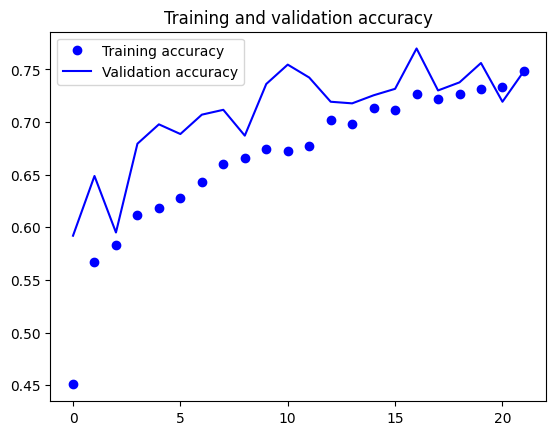

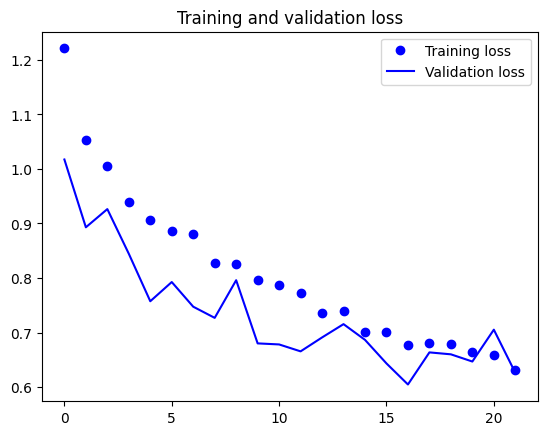

21/21 [==============================] - 4s 146ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.6509    0.8162    0.7242       185
meningioma_tumor     0.7872    0.3957    0.5267       187
        no_tumor     0.7398    0.9100    0.8161       100
 pituitary_tumor     0.8177    0.9222    0.8668       180

        accuracy                         0.7393       652
       macro avg     0.7489    0.7610    0.7335       652
    weighted avg     0.7497    0.7393    0.7210       652



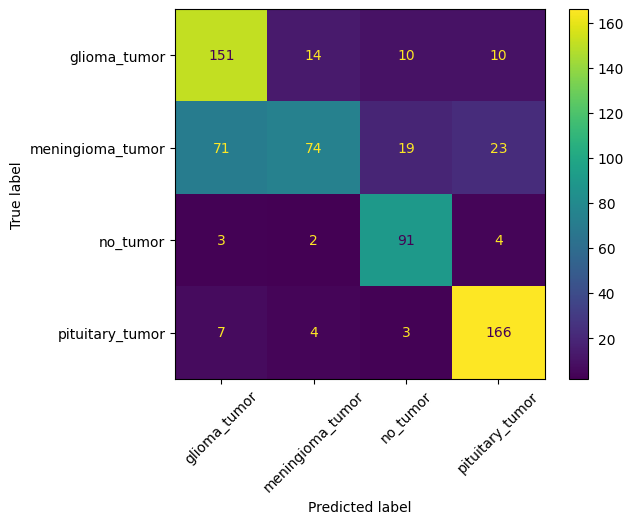

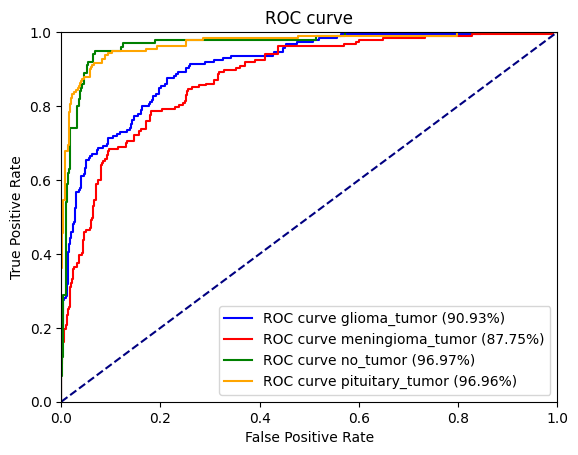

In [9]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax')) #4 classi di output

# freeze the layers of the pretrained model
for layer in base_model.layers:
    layer.trainable = False

# compile the model
compile_model(model)

# run the model
run_model(model, 'ResNet50', "ResNet-50_512_512_GlAvgPool_clahe")

# evaluate the model
evaluate_model(model,test_generator, "ResNet-50_512_512_GlAvgPool_clahe", "ResNet50")

## Experiment 9

We can still see an underfitting scenario. We try to resolve this adding one other dense layer with 512 neurons

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_13 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_14 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_15 (Dense)            (None, 4)                 4100      
                                                      

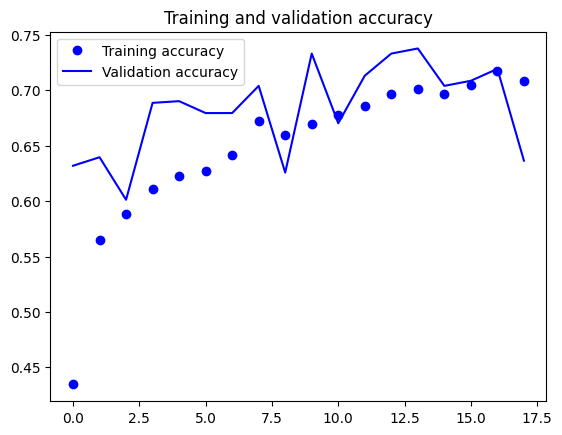

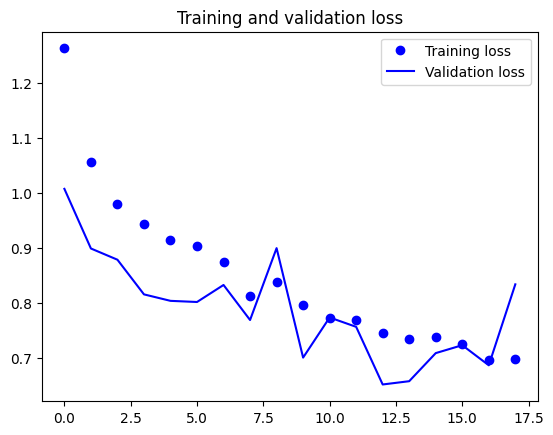

21/21 [==============================] - 4s 144ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.6094    0.6324    0.6207       185
meningioma_tumor     0.7273    0.2567    0.3794       187
        no_tumor     0.4260    0.9500    0.5882       100
 pituitary_tumor     0.8538    0.8111    0.8319       180

        accuracy                         0.6227       652
       macro avg     0.6541    0.6626    0.6051       652
    weighted avg     0.6825    0.6227    0.6048       652



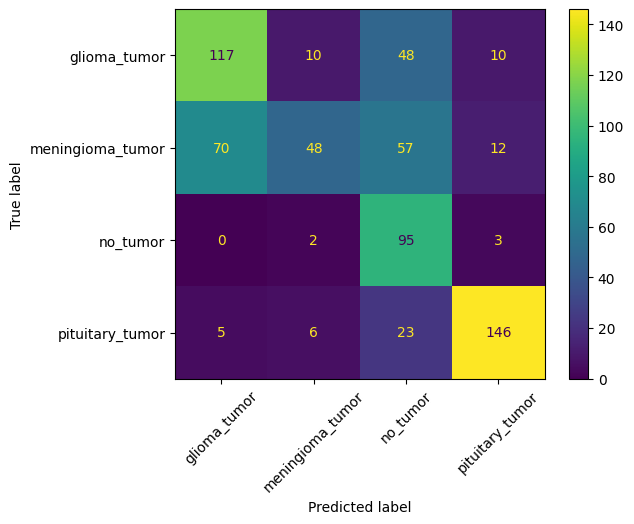

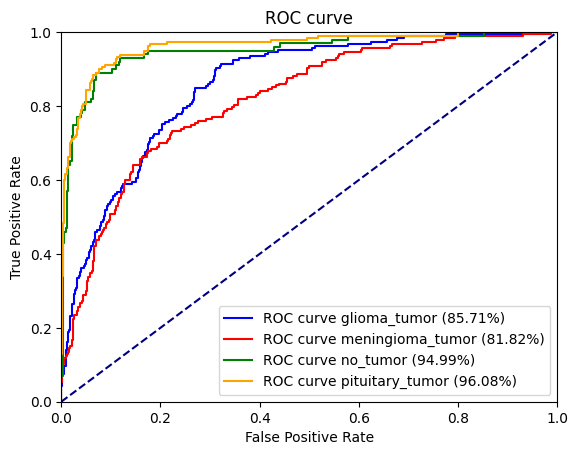

In [10]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(4, activation='softmax'))

# freeze the layers of the pretrained model
for layer in base_model.layers:
    layer.trainable = False

# compile the model
compile_model(model)

# run the model
run_model(model, 'ResNet50', "ResNet-50_1024_1024_1024_globAvgPool_clahe")

# evaluate the model
evaluate_model(model,test_generator, "ResNet-50_1024_1024_1024_globAvgPool_clahe", "ResNet50")

# Fine Tuning

Previous feature extraction experiments have not led to remarkable results. The first experiment turns out to be the most satisfying of all, let's take this as a starting point to proceed with a fine tuning experiment.

## Experiment 1 
Try to increase performance unfreezing last convolutional layers

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_18 (Dense)            (None, 256)               25690368  
                                                                 
 dense_19 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 30,157,060
Non-trainable params: 19,122,048
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 1.8329 - accuracy: 0.4761
Epoch 1: val_loss improved from inf to 1.32013, saving model to /con

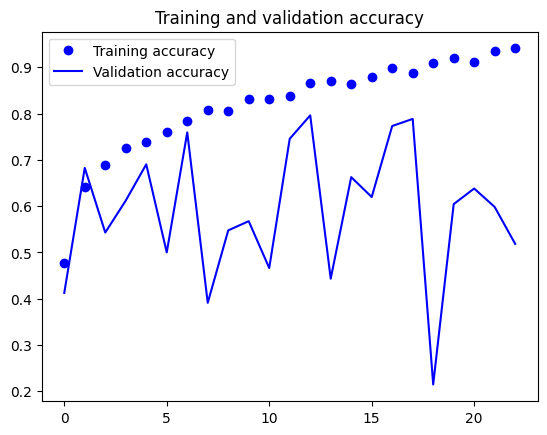

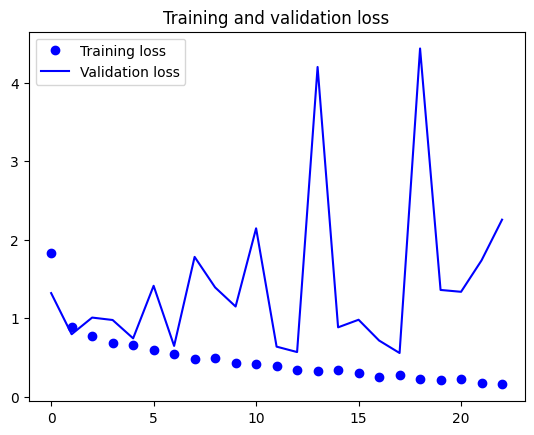

21/21 [==============================] - 4s 149ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.6379    0.6000    0.6184       185
meningioma_tumor     0.9394    0.1658    0.2818       187
        no_tumor     0.3139    0.9700    0.4743       100
 pituitary_tumor     0.9412    0.7111    0.8101       180

        accuracy                         0.5629       652
       macro avg     0.7081    0.6117    0.5462       652
    weighted avg     0.7584    0.5629    0.5527       652



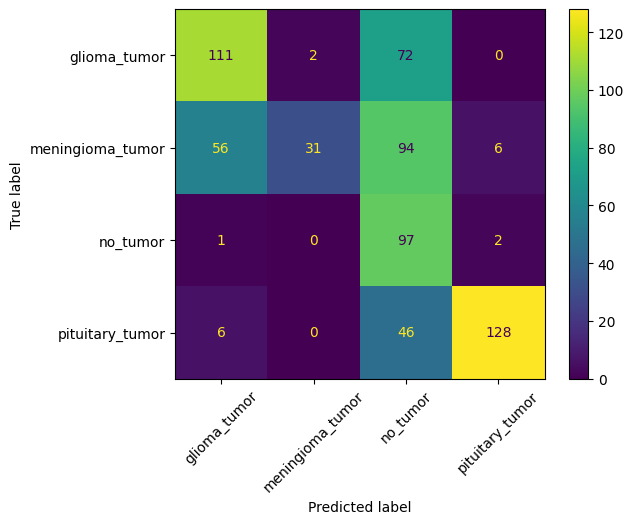

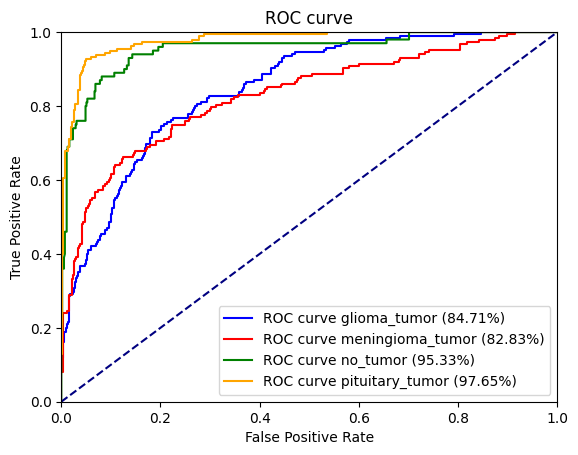

In [13]:
#models_path = dataset_path + "/Models/ResNet50/"
model_name = "ResNet-50_256_clahe"

model = tf.keras.models.load_model(models_path + "/ResNet50/"  + model_name + ".h5")

model.trainable = True
base_model = model.get_layer('resnet50')

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model)

run_model(model, 'ResNet50', "ResNet-50_256_fine_tuning_exp1_clahe")

evaluate_model(model, test_generator, "ResNet-50_256_fine_tuning_exp1_clahe", "ResNet50")

## Experiment 2 
Try to increase performance decreasing learning rate value to 1e-5.

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_18 (Dense)            (None, 256)               25690368  
                                                                 
 dense_19 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 30,157,060
Non-trainable params: 19,122,048
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 1.5378 - accuracy: 0.6509
Epoch 1: val_loss improved from inf to 6.32009, saving model to /con

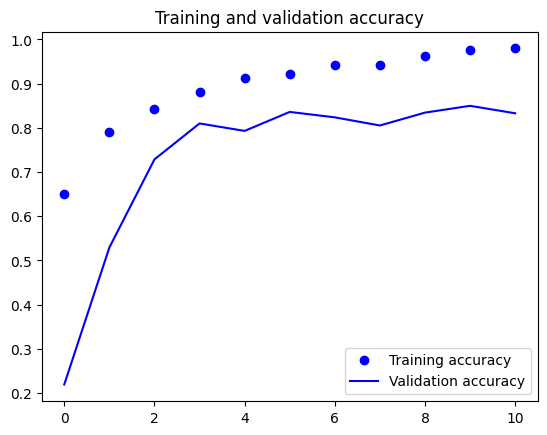

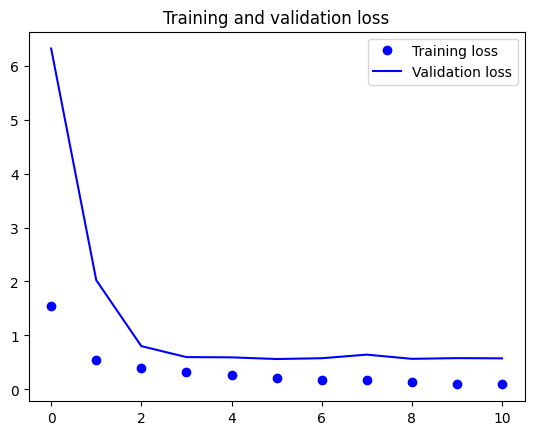

21/21 [==============================] - 5s 188ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.8220    0.8486    0.8351       185
meningioma_tumor     0.8111    0.7807    0.7956       187
        no_tumor     0.8396    0.8900    0.8641       100
 pituitary_tumor     0.9543    0.9278    0.9408       180

        accuracy                         0.8574       652
       macro avg     0.8568    0.8618    0.8589       652
    weighted avg     0.8581    0.8574    0.8574       652



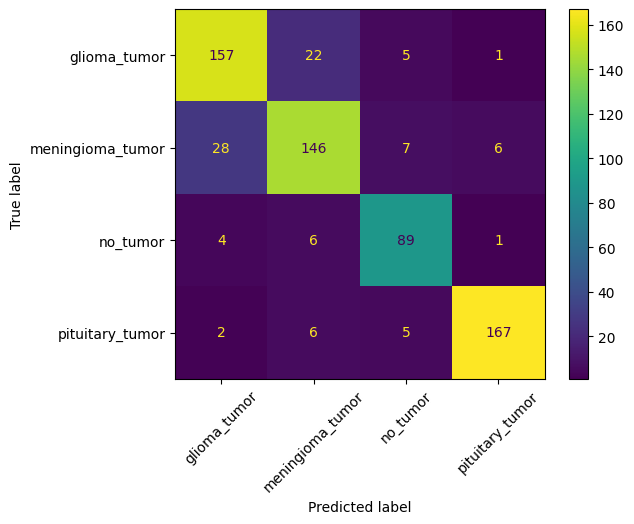

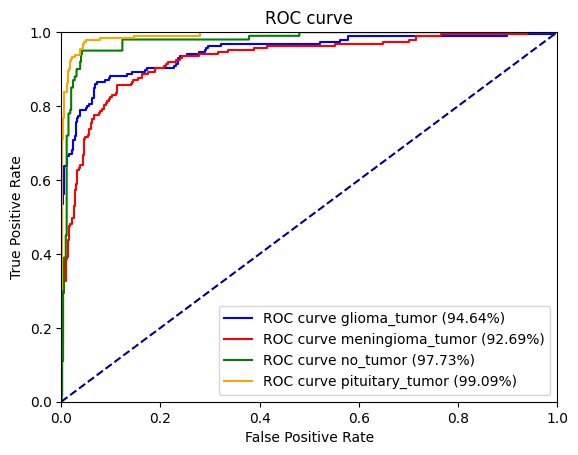

In [14]:
#models_path = dataset_path + "/Models/ResNet50/"
model_name = "ResNet-50_256_clahe"

model = tf.keras.models.load_model(models_path + "/ResNet50/"  + model_name + ".h5")

model.trainable = True
base_model = model.get_layer('resnet50')

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model, learning_rate = 1e-5)

run_model(model, 'ResNet50', "ResNet-50_256_fine_tuning_exp2_clahe")

evaluate_model(model, test_generator, "ResNet-50_256_fine_tuning_exp2_clahe", "ResNet50")

## Experiment 3
Try to increase performance using rmsprop optimizer

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_18 (Dense)            (None, 256)               25690368  
                                                                 
 dense_19 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 30,157,060
Non-trainable params: 19,122,048
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 1.1638 - accuracy: 0.6765
Epoch 1: val_loss improved from inf to 6.01575, saving model to /con

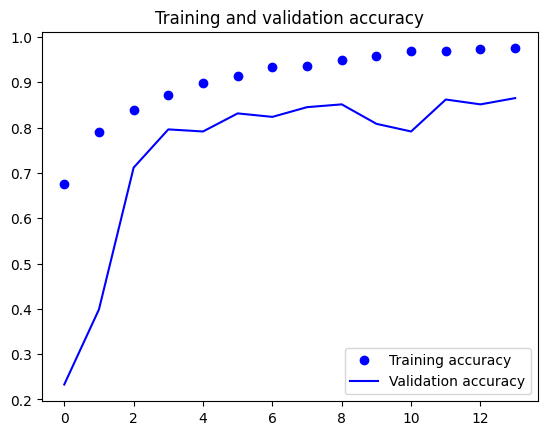

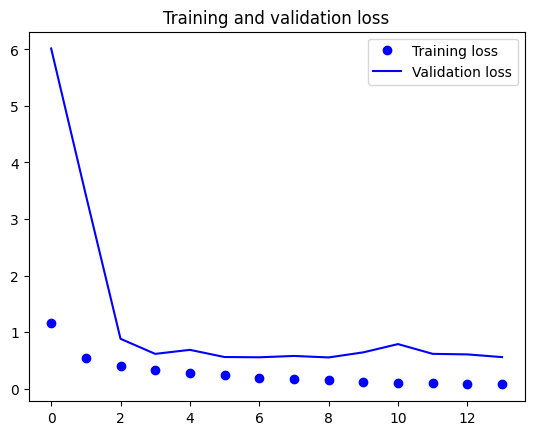

21/21 [==============================] - 4s 146ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.8929    0.8108    0.8499       185
meningioma_tumor     0.7585    0.8396    0.7970       187
        no_tumor     0.8235    0.8400    0.8317       100
 pituitary_tumor     0.9371    0.9111    0.9239       180

        accuracy                         0.8512       652
       macro avg     0.8530    0.8504    0.8506       652
    weighted avg     0.8559    0.8512    0.8524       652



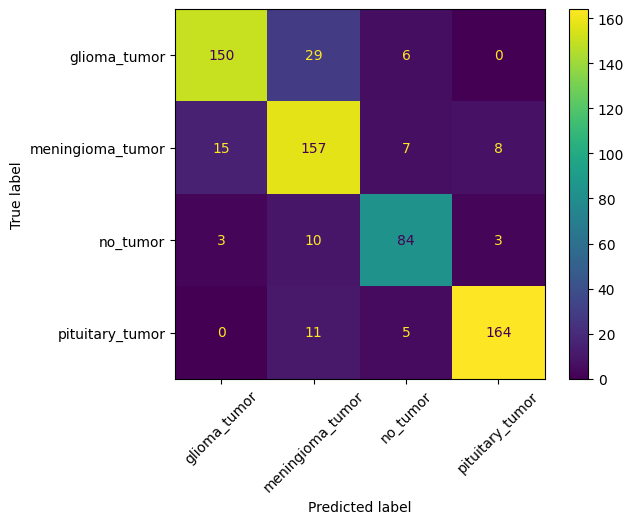

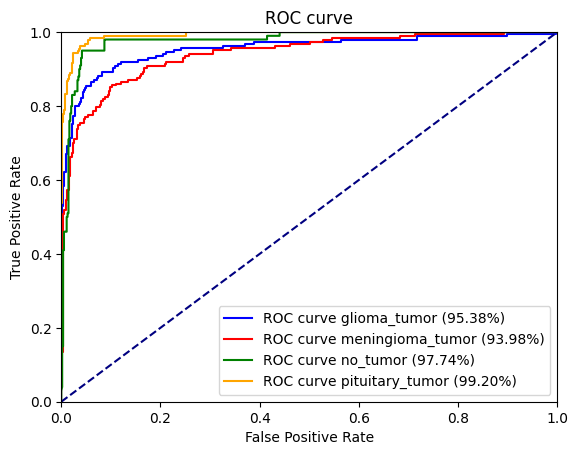

In [15]:
#models_path = dataset_path + "/Models/ResNet50/"
model_name = "ResNet-50_256_clahe"

model = tf.keras.models.load_model(models_path + "/ResNet50/"  + model_name + ".h5")

model.trainable = True
base_model = model.get_layer('resnet50')

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model, optimizer='rmsprop', learning_rate = 1e-5)

run_model(model, 'ResNet50', "ResNet-50_256_fine_tuning_exp3_clahe")

evaluate_model(model, test_generator, "ResNet-50_256_fine_tuning_exp3_clahe", "ResNet50")

## Experiment 4

The performances obtained are not entirely satisfactory because the validation loss value is still high. Let's try to unfreeze other layers of the base model

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_18 (Dense)            (None, 256)               25690368  
                                                                 
 dense_19 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 40,667,396
Non-trainable params: 8,611,712
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 1.8987 - accuracy: 0.6192
Epoch 1: val_loss improved from inf to 5.06460, saving model to /cont

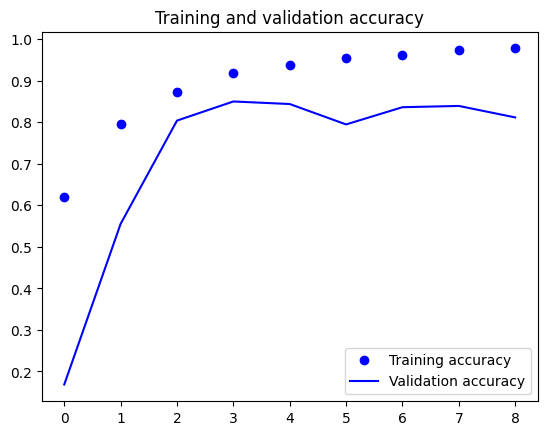

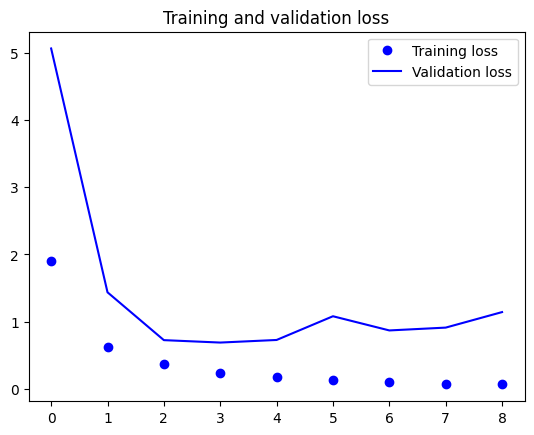

21/21 [==============================] - 4s 145ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.6867    0.9243    0.7880       185
meningioma_tumor     0.9457    0.4652    0.6237       187
        no_tumor     0.7698    0.9700    0.8584       100
 pituitary_tumor     0.9351    0.9611    0.9479       180

        accuracy                         0.8098       652
       macro avg     0.8343    0.8302    0.8045       652
    weighted avg     0.8423    0.8098    0.7958       652



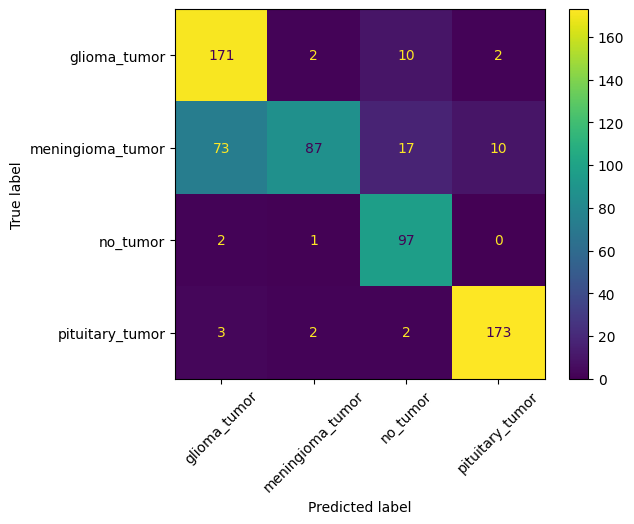

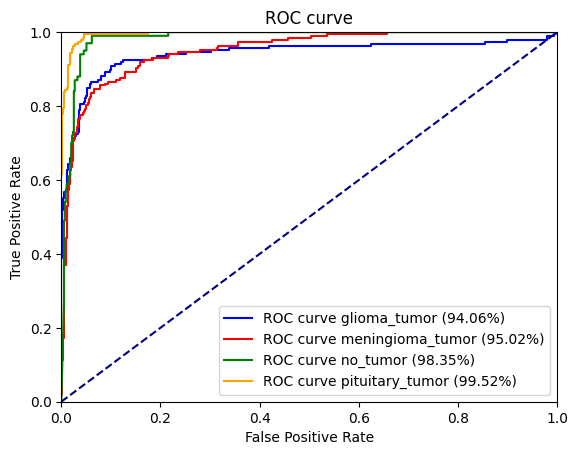

In [16]:
#models_path = dataset_path + "/Models/ResNet50/"
model_name = "ResNet-50_256_clahe"

model = tf.keras.models.load_model(models_path + "/ResNet50/"  + model_name + ".h5")

model.trainable = True
base_model = model.get_layer('resnet50')

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv5_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model, optimizer='rmsprop', learning_rate = 1e-5)

run_model(model, 'ResNet50', "ResNet-50_256_fine_tuning_exp4_clahe")

evaluate_model(model, test_generator, "ResNet-50_256_fine_tuning_exp4_clahe", "ResNet50")

## Remove last block from ResNet50

Since we haven't gotten remarkable results with the experiments performed so far, let's try to eliminate the fifth and last block of the network

In [17]:
def find_layer_index(model, target_layer_name):
    for index, layer in enumerate(model.layers):
      if layer.name == target_layer_name:
        return index

In [18]:
resNet = ResNet50(weights = 'imagenet', include_top = False, input_shape = (image_size, image_size, 3))

custom_base_model = Model(resNet.input, resNet.layers[find_layer_index(resNet, 'conv4_block6_out')].output, name = 'base')
custom_base_model.trainable = False

## Experiment 6
Use the new custom base model without the last block

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_20 (Dense)            (None, 512)               524800    
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dense_22 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 9,378,692
Trainable params: 789,508
Non-trainable params: 8,589,184
______________________________________

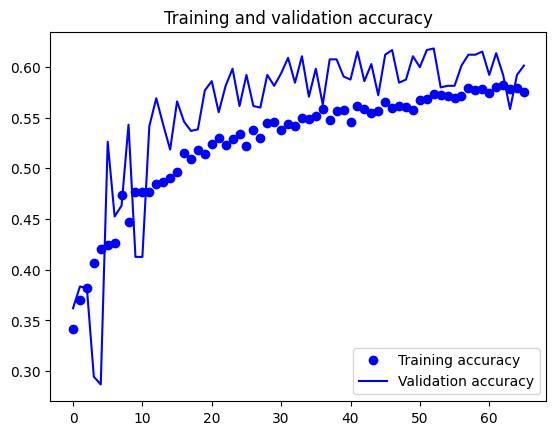

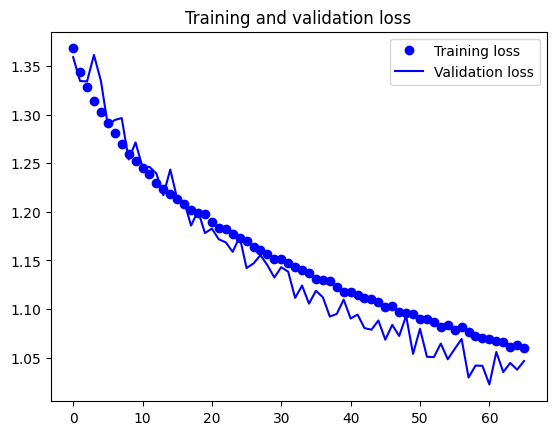

21/21 [==============================] - 4s 145ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.6405    0.5297    0.5799       185
meningioma_tumor     0.5726    0.3797    0.4566       187
        no_tumor     0.5424    0.6400    0.5872       100
 pituitary_tumor     0.6148    0.8778    0.7231       180

        accuracy                         0.5997       652
       macro avg     0.5926    0.6068    0.5867       652
    weighted avg     0.5989    0.5997    0.5852       652



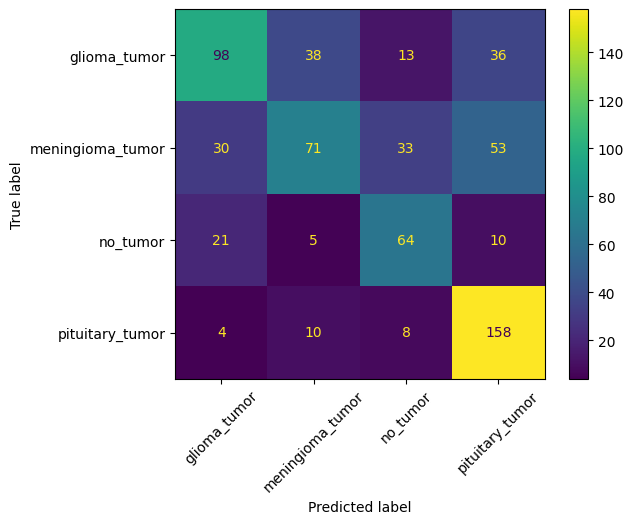

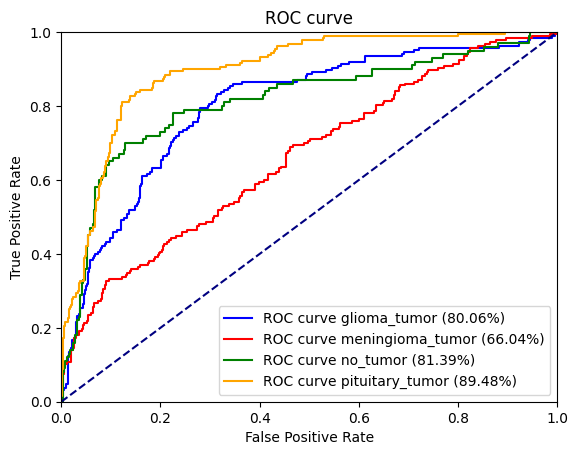

In [19]:
model = Sequential()
model.add(custom_base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))

# freeze the layers of the pretrained model
for layer in custom_base_model.layers:
    layer.trainable = False

# compile the model
compile_model(model, learning_rate=1e-5)

# run the model
run_model(model, 'ResNet50', "ResNet-50_custom_512_512_clahe")

# evaluate the model
evaluate_model(model, test_generator, "ResNet-50_custom_512_512_clahe", "ResNet50")

## Experiment 7

Previous experiment does not lead to remarkable results. Let's try to unfreeze all blocks of the custom base model to see if we can get better results.

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_20 (Dense)            (None, 512)               524800    
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dense_22 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 9,378,692
Trainable params: 789,508
Non-trainable params: 8,589,184
______________________________________

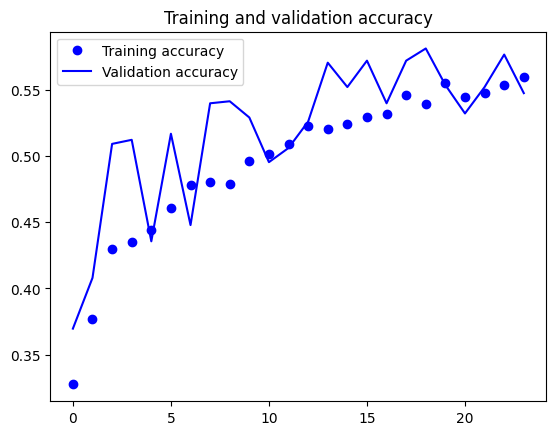

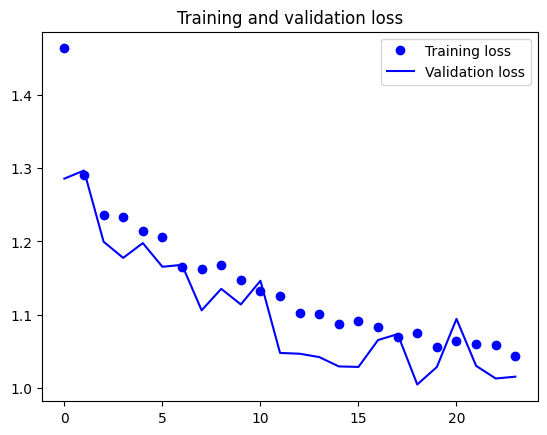

21/21 [==============================] - 4s 139ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.5074    0.7459    0.6039       185
meningioma_tumor     0.3333    0.0535    0.0922       187
        no_tumor     0.5714    0.3200    0.4103       100
 pituitary_tumor     0.5612    0.9167    0.6962       180

        accuracy                         0.5291       652
       macro avg     0.4933    0.5090    0.4506       652
    weighted avg     0.4821    0.5291    0.4529       652



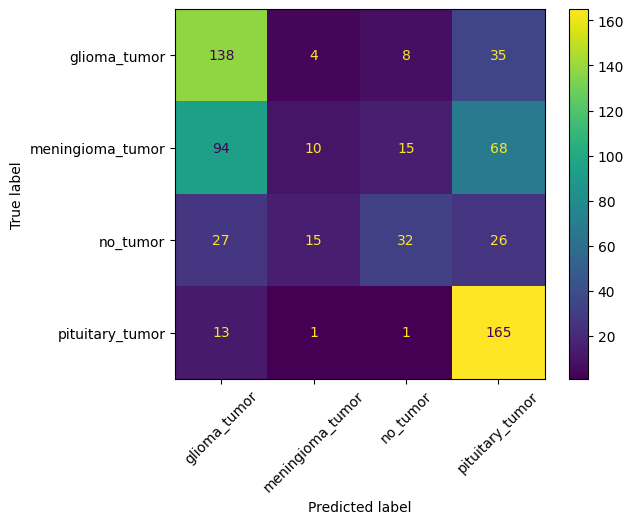

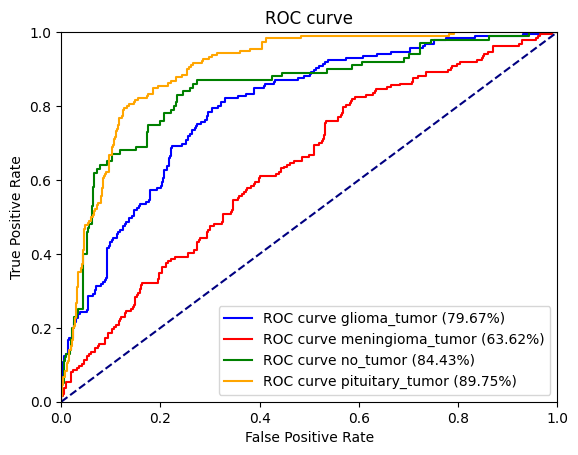

In [25]:
#models_path = dataset_path + "/Models/ResNet50/"
model_name = "ResNet-50_custom_512_512_clahe"

model = tf.keras.models.load_model(models_path + "/ResNet50/"  + model_name + ".h5")

model.trainable = True
base_model = model.get_layer('base')

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv1_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model)

run_model(model, 'ResNet50', "ResNet-50_custom_512_512_fine_tuning_exp7_clahe")

evaluate_model(model, test_generator, "ResNet-50_custom_512_512_fine_tuning_exp7_clahe", "ResNet50")